In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib import colormaps
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from scipy.stats import spearmanr
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib

%matplotlib inline

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data, read_transcription_data, read_embedding_data
from plot import draw_start, draw_path, draw_clusters
from graph import compute_distance_matrix, compute_path_idxs, compute_clusters, compute_path_counts

In [2]:
def draw_circles(spot_radius, pos_df, alpha):
    circs = PatchCollection(
        [Circle((x, y), spot_radius) for x, y in pos_df[["x", "y"]].to_numpy()],
        picker=True,
    )
    facecolors = np.asarray([list(to_rgba("lightgray"))] * len(pos_df))
    edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(pos_df))
    alphas = np.full(len(pos_df), alpha)
    circs.set_facecolor(facecolors)
    circs.set_edgecolor(edgecolors)
    circs.set_alpha(alphas)
    return circs, facecolors, edgecolors, alphas

/tmp/ipykernel_1917958/3069591828.py:109: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


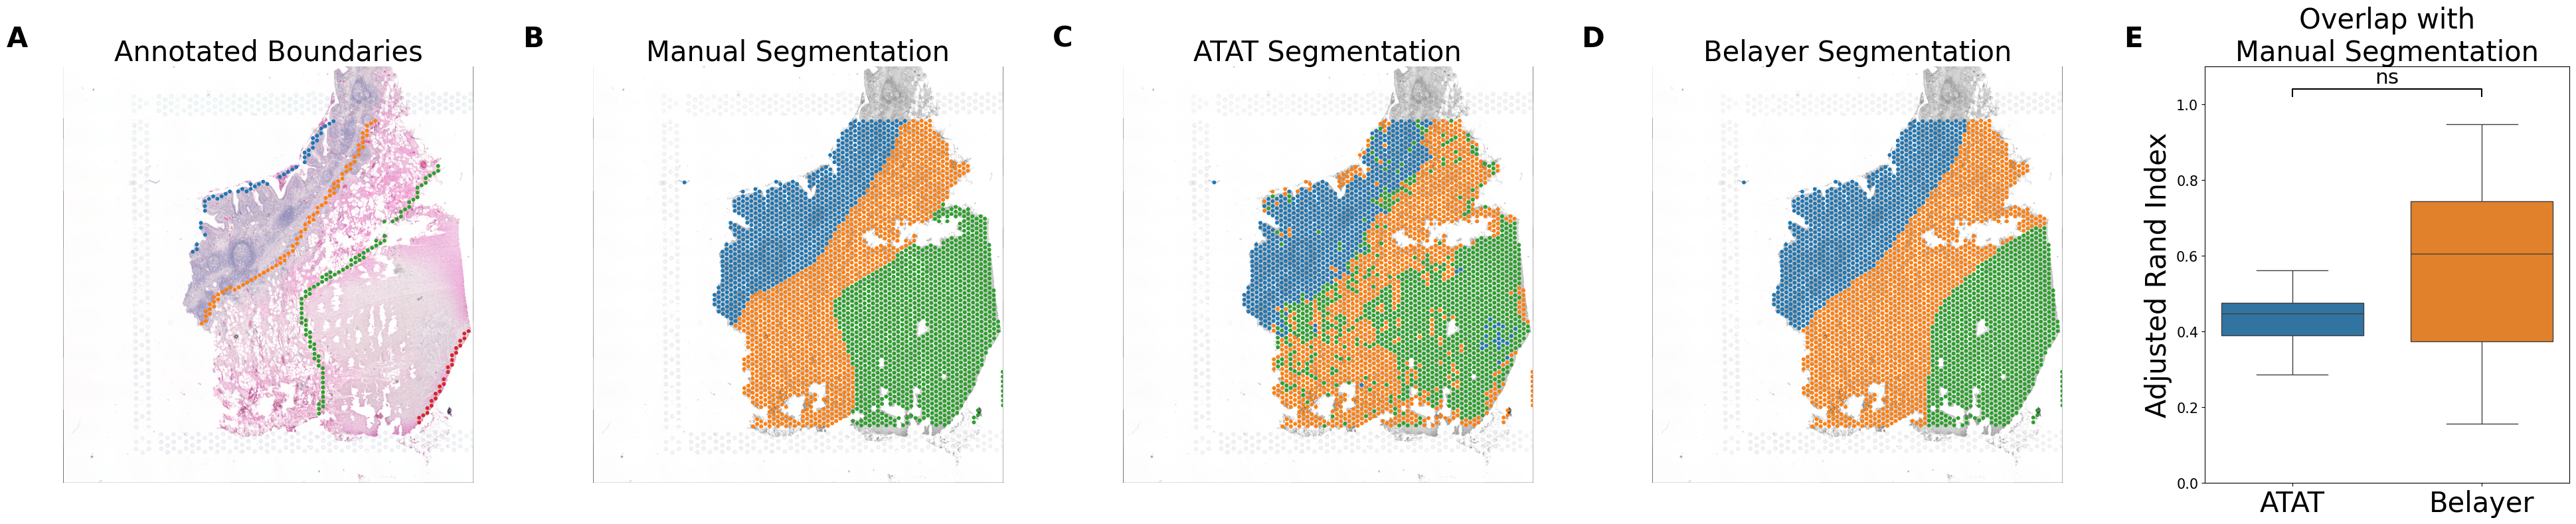

In [43]:
dz = "UC"
section = "A"
start_idx, end_idx = 2525, 213
model = 'triplet-gi-0999'
fullres = False
figsize = 8
fontsize = 15
alpha = 1
nrows = 1
ncols = 5
plt.close()
fig, axs = plt.subplots(nrows, ncols, figsize=(figsize * ncols, figsize * nrows), constrained_layout=True)
ax0, ax1, ax2, ax3, ax4 = axs
for ax in axs.flatten()[:-1]:
    ax.set_axis_off()

# ATAT alignment
section_path = f'/mnt/data1/spatial/data/colon/{dz}/{section}'
im = read_image(section_path, fullres)
pos_df, spot_radius = read_spatial_data(section_path, fullres)
embeds = read_embedding_data(section_path, model)
dists, hex = compute_distance_matrix(embeds, pos_df)
path_idxs = compute_path_idxs(dists, hex, start_idx, end_idx)
clusters = compute_clusters(embeds, embeds[path_idxs])

# ATAT pseudosegmentation
layers = pd.read_csv(f'colon/colon-{dz}-{section}-layers.csv')
pos_df['layer'] = layers['layer']
prev_layer = pos_df.loc[path_idxs[0], 'layer']
path_bounds = [0]
for j, path_idx in enumerate(path_idxs[1:]):
    j += 1
    cur_layer = pos_df.loc[path_idx, 'layer']
    if cur_layer != prev_layer:
        path_bounds.append(j)
        prev_layer = cur_layer
assert len(path_bounds) == len(pos_df['layer'].drop_duplicates())
path_bounds.append(len(path_idxs))
cluster_to_layer = {}
layer = 0
for j in range(len(path_idxs)):
    if j == path_bounds[layer + 1]:
        layer += 1
    cluster_to_layer[j] = layer
pos_df['atat-layer'] = [cluster_to_layer[c] for c in clusters]

# Belayer alignment and segmentation
belayer = pd.read_csv(f'colon/colon-{dz}-{section}-belayer.csv')
pos_df[['depth', 'depth2', 'belayer-layer']] = belayer[['depth', 'depth2', 'belayer-layer']]
boundary_file=f'colon/colon-{dz}-{section}-boundaries.npy'
temp = np.load(boundary_file, allow_pickle=True)
bounds = []
for b in temp:
    # convert row, col matrix to list of indices
    mask = [f'{row}-{col}' for row, col in b]
    row_col = pd.DataFrame(
        {'idx': np.arange(len(pos_df))},
        index=pos_df['row'].astype(str) + "-" + pos_df['col'].astype(str)
    )
    bounds.append(row_col.loc[mask, 'idx'].to_numpy())

# Draw hexagonal grid over grayscale H&E
row_circs = []
for ax in axs[1:-1]:
    ax.imshow(np.asarray(im.convert("L")), cmap='gray', vmin=0, vmax=255)
    circs_etc = draw_circles(spot_radius, pos_df, alpha)
    row_circs.append(circs_etc)
    ax.add_collection(circs_etc[0])

# Draw boundaries over color H&E
ax0.imshow(im)
cmap = colormaps['tab10']
for j, b in enumerate(bounds):
    bound_coords = pos_df.loc[b, ['x', 'y']].sort_values('y').to_numpy()
    for x, y in bound_coords:
        circ = Circle((x, y), spot_radius, color=cmap(j))
        ax0.add_artist(circ)

# ARI box plot with sig
ARIs = pd.read_csv('colon-ARIs.csv')
df = pd.DataFrame({
    'ARI': list(ARIs['ATAT']) + list(ARIs['Belayer']),
    'Method': [0] * 8 + [0.5] * 8,
    'Disease': ['CD'] * 4 + ['UC'] * 4 + ['CD'] * 4 + ['UC'] * 4,
})
x = "Method"
y = "ARI"

sns.boxplot(data=df, x=x, y=y, ax=ax4, hue=x, legend=False, palette=['tab:blue', 'tab:orange'], native_scale=True, width=0.75)
ax4.set_ylim([0, 1.1])
# ax4.set_xlabel('Method', fontsize=fontsize*2)
ax4.set_xlabel('')
ax4.set_ylabel('Adjusted Rand Index', fontsize=fontsize*2)
ax4.plot([0, 0, 0.5, 0.5], [1.02, 1.04, 1.04, 1.02], color='black')
ax4.annotate('ns', (0.25, 1.045), ha='center', va='bottom', fontsize=fontsize*1.5)

def fix_labels(ax):
    ax.tick_params(axis='both', labelsize=fontsize)
fix_labels(ax4)
ax4.set_xticks([0, 0.5])
ax4.set_xticklabels(['ATAT', 'Belayer'], fontsize=fontsize*2)

ax0.set_title('Annotated Boundaries', fontsize=fontsize*2)
ax1.set_title('Manual Segmentation', fontsize=fontsize*2)
ax2.set_title('ATAT Segmentation', fontsize=fontsize*2)
ax3.set_title('Belayer Segmentation', fontsize=fontsize*2)
ax4.set_title('Overlap with\nManual Segmentation', fontsize=fontsize*2)

fig.tight_layout()
ax4.set_aspect('equal', 'box')
plt.subplots_adjust(left=0.025)

def _panel_label_coords(left_ax, right_ax, yoffset=0.1):
    right_bbox = right_ax.get_position()
    if left_ax is None:
        leftx = 0
    else:
        leftx = left_ax.get_position().xmax
    x = (right_bbox.xmin - leftx) / 2 + leftx
    # x = bbox.xmin - bbox.width * xoffset
    y = right_bbox.ymax + right_bbox.height * yoffset
    return x, y

from string import ascii_uppercase
for ax_left, ax_right, letter in zip([None] + list(axs.flatten()[:-1]), axs.flatten(), ascii_uppercase):
    fig.text(*_panel_label_coords(ax_left, ax_right), letter, ha='center', va='top', fontsize=fontsize*2, weight='bold')

# Draw Manual Segmentation
circs, facecolors, edgecolors, alphas = row_circs[0]
dummy_path_idxs_seg = [-1] * (len(bounds)-1)
draw_clusters(
    fig=fig,
    ax=ax1,
    path_idxs=dummy_path_idxs_seg,
    clusters=pos_df['layer'].astype(int),
    circs=circs,
    facecolors=facecolors,
    edgecolors=edgecolors,
    cm_name='tab10',
    show_cbar=False,
    discrete_cm=True,
    fontsize=fontsize,
)

# Draw ATAT Segmentation
circs, facecolors, edgecolors, alphas = row_circs[1]
dummy_path_idxs_seg = [-1] * (len(bounds)-1)
draw_clusters(
    fig=fig,
    ax=ax2,
    path_idxs=dummy_path_idxs_seg,
    clusters=pos_df['atat-layer'].astype(int),
    circs=circs,
    facecolors=facecolors,
    edgecolors=edgecolors,
    cm_name='tab10',
    show_cbar=False,
    discrete_cm=True,
    fontsize=fontsize,
)

# Draw Belayer Segmentation
circs, facecolors, edgecolors, alphas = row_circs[2]
dummy_path_idxs_seg = [-1] * (len(bounds)-1)
draw_clusters(
    fig=fig,
    ax=ax3,
    path_idxs=dummy_path_idxs_seg,
    clusters=pos_df['belayer-layer'].astype(int),
    circs=circs,
    facecolors=facecolors,
    edgecolors=edgecolors,
    cm_name='tab10',
    show_cbar=False,
    discrete_cm=True,
    fontsize=fontsize,
)

fig.savefig(f'figs/fig5.png')
fig.savefig(f'figs/fig5.pdf')

In [1]:
from scipy.stats import ttest_ind
import pandas as pd

In [2]:
ARIs = pd.read_csv('colon-ARIs.csv')
ttest_ind(ARIs['ATAT'], ARIs['Belayer'])

TtestResult(statistic=-1.4372340903743839, pvalue=0.17262445852694072, df=14.0)

In [5]:
print(ARIs.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Disease & Section & ATAT & Belayer \\
\midrule
CD & A & 0.337775 & 0.945971 \\
CD & B & 0.461042 & 0.721331 \\
CD & C & 0.561651 & 0.813069 \\
CD & D & 0.457358 & 0.155741 \\
UC & A & 0.436816 & 0.655275 \\
UC & B & 0.286321 & 0.554804 \\
UC & C & 0.515088 & 0.376477 \\
UC & D & 0.406012 & 0.365828 \\
\bottomrule
\end{tabular}

